# N170 with Muse

This experiment consisted in the presentation of face and house images, in order to elicit the N170 potential. 

Stimuli were presented for 200 ms with an intertrial interval of 400 ms and random jitter of ±100ms. The task was to mentally note whether a "face" or a "house" was presented. Six blocks of 2 min were recorded for a single partipant.

The stimuli set consisted in 12 grayscale pictures of centered human faces for the "face" condition, and in 12 grayscale pictures of houses for the "face" condition. The pictures were obtained from:

> Haxby, J., Gobbini, M., Furey, M., Ishai, A., Schouten, J., and Pietrini, P. (2001). 
Distributed and overlapping representations of faces and objects in ventral temporal 
cortex. Science 293, 2425–2430.

In [123]:
import os
import sys
from collections import OrderedDict

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

sys.path.append('../utils')
import utils

## Load data into MNE objects

In [124]:
subject = 3
session = 2
raw = utils.load_data('visual/N170', sfreq=256., 
                      subject_nb=subject, session_nb=session)

Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30720
    Range : 0 ... 30719 =      0.000 ...   119.996 secs
Ready.


## Power Spectrum

tmax defaults to 60. in 0.14 but will change to np.inf in 0.15. Set it explicitly to avoid this warning
Effective window size : 8.000 (s)


<ipython-input-125-41b050882633>:1: DeprecationWarning: tmax defaults to 60. in 0.14 but will change to np.inf in 0.15. Set it explicitly to avoid this warning
  raw.plot_psd();
/home/dano/anaconda3/lib/python3.6/site-packages/mne/viz/raw.py:614: DeprecationWarning: In version 0.15 average will default to False and spatial_colors will default to True.
  'spatial_colors will default to True.', DeprecationWarning)


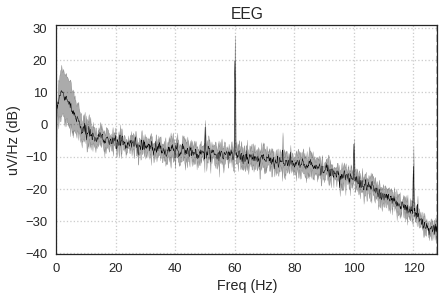

In [125]:
raw.plot_psd();

## Filtering

We filter data between 1 and 30 Hz.

In [126]:
raw.filter(1,30, method='iir')

Setting up band-pass filter from 1 - 30 Hz


<RawArray  |  None, n_channels x n_times : 5 x 61452 (240.0 sec), ~2.4 MB, data loaded>

## Epoching

Here we epoch data for -100ms to 800ms after the stimulus. No baseline correction is needed (signal is bandpass filtered) and we reject every epochs were the signal exceed 75 uV. This mainly rejects blinks.

In [127]:
from mne import Epochs, find_events

events = find_events(raw)
event_id = {'House': 1, 'Face': 2}

epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=-0.1, tmax=0.8, baseline=None,
                reject={'eeg': 100e-6}, preload=True, 
                verbose=False, picks=[0,1,2,3])
print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)
epochs

395 events found
Events id: [1 2]
sample drop %:  13.924050632911388


<Epochs  |  n_events : 340 (all good), tmin : -0.1015625 (s), tmax : 0.80078125 (s), baseline : None, ~2.4 MB, data loaded,
 'Face': 166, 'House': 174>

## Epoch average

Now we can plot the average ERP for both conditions:

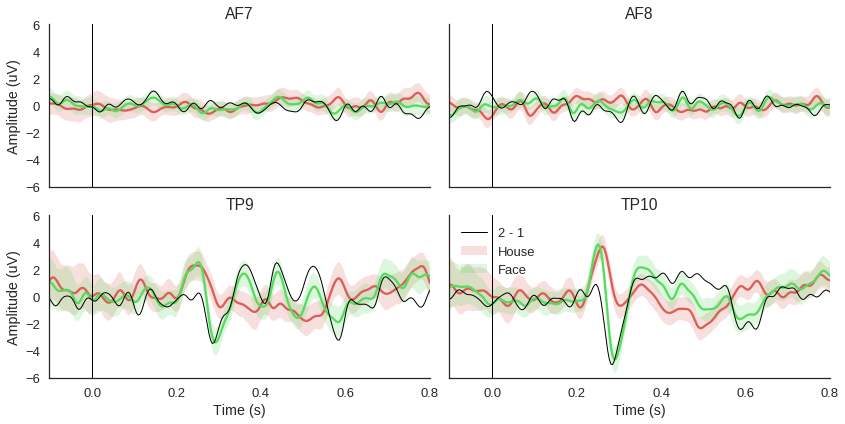

In [128]:
conditions = OrderedDict()
conditions['House'] = [1]
conditions['Face'] = [2]

fig, ax = utils.plot_conditions(epochs, conditions=conditions, 
                                ci=97.5, n_boot=1000, title='',
                                diff_waveform=(1, 2))

He have a very nice deflection in the temporal channels for face stimuli. This is likely the N170, although delayed in the data by around 100ms due to bluetooth delay and timestamping issues. The positive deflection right before it might be the P100 component.

## Decoding

Here is will use 4 different pipelines to classify between the two conditions:

- **Vect + LR** :  Vectorization of the trial + Logistic Regression. This can be considered as the standard decoding pipeline in MEG / EEG.
- **Vect + RegLDA** :  Vectorization of the trial + Regularized LDA. This one is very used in P300 BCI. It can outperform the previous one but can become unusable if the number of dimension is too high.
- **ERPCov + TS**: ErpCovariance + Tangent space mapping. One of my favorite Riemannian geometry based pipeline.
- **ERPCov + MDM**: ErpCovariance + MDM. A very simple, yet effective (for low channel count), Riemannian geometry classifier.

Evaluation is done in cross-validation, with AUC as metric (AUC is probably the best metric for binary and unbalanced classification problem)

In [129]:
from sklearn.pipeline import make_pipeline

from mne.decoding import Vectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit

from pyriemann.estimation import ERPCovariances, XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM

from collections import OrderedDict

clfs = OrderedDict()

clfs['Vect + LR'] = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression())
clfs['Vect + RegLDA'] = make_pipeline(Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs['ERPCov + TS'] = make_pipeline(ERPCovariances(estimator='oas'), TangentSpace(), LogisticRegression())
clfs['ERPCov + MDM'] = make_pipeline(ERPCovariances(estimator='oas'), MDM())
clfs['XdawnCov + TS'] = make_pipeline(XdawnCovariances(estimator='oas'), TangentSpace(), LogisticRegression())
clfs['XdawnCov + MDM'] = make_pipeline(XdawnCovariances(estimator='oas'), MDM())

# format data
epochs.pick_types(eeg=True)
X = epochs.get_data() * 1e6
times = epochs.times
y = epochs.events[:, -1]

# define cross validation 
cv = StratifiedShuffleSplit(n_splits=20, test_size=0.25, 
                            random_state=42)

# run cross validation for each pipeline
auc = []
methods = []
for m in clfs:
    print(m)
    try:
        res = cross_val_score(clfs[m], X, y==2, scoring='roc_auc', 
                              cv=cv, n_jobs=-1)
        auc.extend(res)
        methods.extend([m]*len(res))
    except:
        pass
    
results = pd.DataFrame(data=auc, columns=['AUC'])
results['Method'] = methods

Vect + LR
Vect + RegLDA
ERPCov + TS
ERPCov + MDM
XdawnCov + TS
XdawnCov + MDM


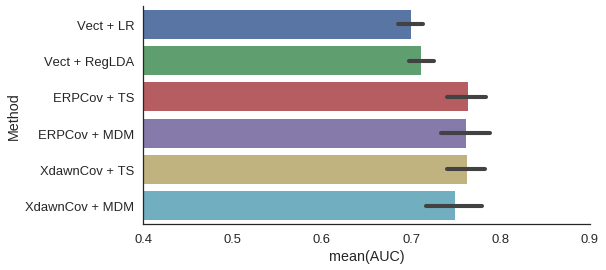

In [130]:
fig = plt.figure(figsize=[8,4])
sns.barplot(data=results, x='AUC', y='Method')
plt.xlim(0.4, 0.9)
sns.despine()

The best classifiers are the ERPCov and XdawnCov with tangent space projections. AUC is around .77, which is pretty good!